
STEP 3: REMOVING OBJECTS
🔄 Removing objects from frames...
  Progress: 20/200 frames
  Progress: 40/200 frames
  Progress: 60/200 frames
  Progress: 80/200 frames
  Progress: 100/200 frames
  Progress: 120/200 frames
  Progress: 140/200 frames
  Progress: 160/200 frames
  Progress: 180/200 frames
  Progress: 200/200 frames
✅ SUCCESS! Processed 200 frames
✅ Video saved to videos/cleaned_bedroom.mp4


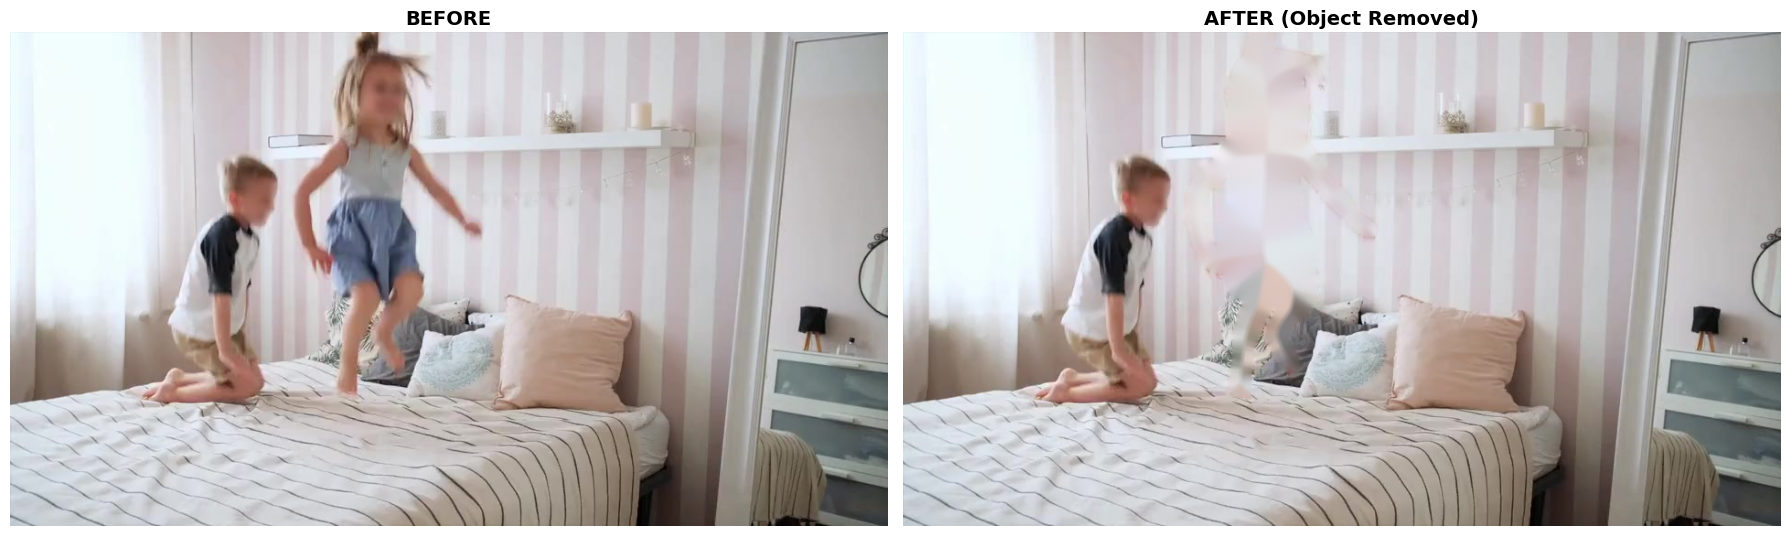


🎉 DONE! Your video is ready!
📁 File: videos/cleaned_bedroom.mp4

⬇️ Downloading file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Video segmentation with SAM 2 - VideoClean with Manual Clicking

# Environment Set-up
using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

# Set-up
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab import output
from IPython.display import display, HTML, clear_output, Image as IPImage
import ipywidgets as widgets
from io import BytesIO

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

# VideoClean Application with Manual Clicking
class VideoObjectRemover:
    def __init__(self, predictor, device="cuda"):
        self.predictor = predictor
        self.device = device
        self.click_points = []
        self.click_labels = []
        self.current_frame_idx = 0
        self.frames_dir = None
        self.num_frames = 0
        self.inference_state = None
        self.video_segments = {}
        self.fps = 30

    def load_from_directory(self, frames_dir):
        """Load video from a directory of JPG frames"""
        if not os.path.exists(frames_dir):
            print(f"Directory {frames_dir} does not exist!")
            return False

        self.frames_dir = frames_dir

        # Count frames
        frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        self.num_frames = len(frame_files)

        if self.num_frames == 0:
            print(f"No image frames found in {frames_dir}")
            return False

        print(f"Found {self.num_frames} frames in {frames_dir}")

        # Initialize the inference state with the frames directory
        self.inference_state = self.predictor.init_state(video_path=frames_dir)
        print("✓ Video loaded and initialized successfully!")

        return True

    def load_video(self, video_path):
        """Load video and extract frames to temporary directory"""
        import tempfile

        # Create temporary directory for frames
        temp_dir = tempfile.mkdtemp()
        frame_dir = os.path.join(temp_dir, "frames")
        os.makedirs(frame_dir, exist_ok=True)

        # Extract frames
        cap = cv2.VideoCapture(video_path)
        self.fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = 0

        print("Extracting frames from video...")
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(frame_dir, f"{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_count += 1

            if frame_count % 30 == 0:
                print(f"Extracted {frame_count} frames...")

        cap.release()
        self.num_frames = frame_count
        print(f"✓ Extracted {self.num_frames} frames to {frame_dir}")

        # Initialize the inference state
        self.frames_dir = frame_dir
        self.inference_state = self.predictor.init_state(video_path=frame_dir)
        print("✓ Video initialized successfully!")

        return frame_dir

    def get_frame(self, frame_idx):
        """Get a specific frame"""
        if self.frames_dir is None:
            return None

        frame_path = os.path.join(self.frames_dir, f"{frame_idx:05d}.jpg")

        if os.path.exists(frame_path):
            frame = cv2.imread(frame_path)
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return None

    def add_click(self, x, y, is_positive=True):
        """Add a click point for object selection"""
        self.click_points.append([x, y])
        self.click_labels.append(1 if is_positive else 0)
        point_type = "POSITIVE (include)" if is_positive else "NEGATIVE (exclude)"
        print(f"✓ Added {point_type} point at ({x}, {y})")

    def clear_clicks(self):
        """Clear all click points"""
        self.click_points = []
        self.click_labels = []
        self.video_segments = {}
        print(" All clicks cleared")

    def display_frame_with_clicks(self, frame_idx=0):
        """Display a frame with current click points"""
        frame = self.get_frame(frame_idx)
        if frame is None:
            print(f"Could not load frame {frame_idx}!")
            return

        # Create figure with clicks
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.imshow(frame)

        # Plot click points with large, visible markers
        for i, (x, y) in enumerate(self.click_points):
            if self.click_labels[i] == 1:
                # Positive click - green star
                ax.plot(x, y, marker='*', color='lime', markersize=30,
                       markeredgecolor='white', markeredgewidth=3, zorder=10)
                ax.text(x, y-30, f'✓ {i+1}', color='white', fontsize=14,
                       fontweight='bold', ha='center',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.9))
            else:
                # Negative click - red X
                ax.plot(x, y, marker='x', color='red', markersize=30,
                       markeredgecolor='white', markeredgewidth=5, zorder=10)
                ax.text(x, y-30, f'✗ {i+1}', color='white', fontsize=14,
                       fontweight='bold', ha='center',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.9))

        # Title with click count
        if len(self.click_points) == 0:
            title = "No clicks yet - Use the input boxes below to add points"
            title_color = 'red'
        else:
            title = f"✓ {len(self.click_points)} point(s) selected"
            title_color = 'green'

        ax.set_title(title, fontsize=16, fontweight='bold', color=title_color, pad=20)
        ax.axis('off')

        plt.tight_layout()
        plt.show()

        # Print summary
        if len(self.click_points) > 0:
            print("\n" + "="*50)
            print(" SELECTED POINTS:")
            print("="*50)
            for i, (x, y) in enumerate(self.click_points):
                point_type = "✓ Positive (Include)" if self.click_labels[i] == 1 else "✗ Negative (Exclude)"
                print(f"  Point {i+1}: X={x}, Y={y} - {point_type}")
            print("="*50)
        else:
            print("\n  No points selected yet!")

    def generate_masks(self):
        """Generate masks for the selected object across all frames"""
        if not self.click_points:
            print("❌ No clicks added! Please add click points first.")
            return None

        if self.inference_state is None:
            print("❌ No video loaded!")
            return None

        # Reset predictor
        self.predictor.reset_state(self.inference_state)

        # Convert clicks to numpy arrays
        points = np.array(self.click_points, dtype=np.float32)
        labels = np.array(self.click_labels, np.int32)

        print(f"🔄 Processing {len(points)} click points on frame {self.current_frame_idx}...")

        # Add points to the first frame
        _, out_obj_ids, out_mask_logits = self.predictor.add_new_points(
            inference_state=self.inference_state,
            frame_idx=self.current_frame_idx,
            obj_id=1,
            points=points,
            labels=labels,
        )

        print(f"✓ Points added successfully!")
        print("🔄 Propagating masks through entire video... (this may take 20-30 seconds)")

        # Propagate through the entire video
        self.video_segments = {}
        for out_frame_idx, out_obj_ids, out_mask_logits in self.predictor.propagate_in_video(
            self.inference_state
        ):
            self.video_segments[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

        print(f"SUCCESS! Generated masks for {len(self.video_segments)} frames")
        return self.video_segments

    def remove_objects(self, inpaint_method='telea'):
        """Remove selected objects using inpainting"""
        if not self.video_segments:
            print("No masks generated. Please generate masks first.")
            return None

        cleaned_frames = []

        print("Removing objects from frames...")
        for frame_idx in range(self.num_frames):
            frame = self.get_frame(frame_idx)
            if frame is None:
                continue

            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            if frame_idx in self.video_segments:
                masks = self.video_segments[frame_idx]
                combined_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

                for obj_id, mask in masks.items():
                    mask_2d = mask.squeeze()
                    combined_mask = np.logical_or(combined_mask, mask_2d).astype(np.uint8)

                mask_uint8 = (combined_mask * 255).astype(np.uint8)

                # Dilate mask slightly
                kernel = np.ones((3, 3), np.uint8)
                mask_uint8 = cv2.dilate(mask_uint8, kernel, iterations=2)

                # Inpaint
                if inpaint_method == 'telea':
                    inpainted_frame = cv2.inpaint(frame_bgr, mask_uint8, 7, cv2.INPAINT_TELEA)
                else:
                    inpainted_frame = cv2.inpaint(frame_bgr, mask_uint8, 7, cv2.INPAINT_NS)

                cleaned_frames.append(cv2.cvtColor(inpainted_frame, cv2.COLOR_BGR2RGB))
            else:
                cleaned_frames.append(frame)

            if (frame_idx + 1) % 20 == 0:
                print(f"  Progress: {frame_idx + 1}/{self.num_frames} frames")

        print(f" SUCCESS! Processed {len(cleaned_frames)} frames")
        return cleaned_frames

    def save_video(self, frames, output_path, fps=None):
        """Save processed frames as a video"""
        if not frames:
            print("No frames to save!")
            return False

        if fps is None:
            fps = self.fps

        height, width = frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        for frame in frames:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)

        out.release()
        print(f" Video saved to {output_path}")
        return True

# Initialize
video_clean = VideoObjectRemover(predictor, device=device)

# Load bedroom dataset
print("="*60)
print("LOADING VIDEO")
print("="*60)
success = video_clean.load_from_directory("videos/bedroom")

if not success:
    print("Failed to load video")
else:
    print(" Video loaded successfully!\n")

    # Display initial frame
    video_clean.display_frame_with_clicks(0)

    print("\n" + "="*60)
    print("STEP 1: ADD CLICK POINTS")
    print("="*60)
    print("Use the input boxes below to add points on the object")

    # Create interactive widgets for adding clicks
    x_input = widgets.IntText(
        value=400,
        description='X coordinate:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='300px')
    )

    y_input = widgets.IntText(
        value=300,
        description='Y coordinate:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='300px')
    )

    point_type = widgets.Dropdown(
        options=[('Positive (Include)', 1), ('Negative (Exclude)', 0)],
        value=1,
        description='Point Type:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='300px')
    )

    add_point_btn = widgets.Button(
        description=" Add Point",
        button_style='info',
        layout=widgets.Layout(width='150px', height='40px')
    )

    show_frame_btn = widgets.Button(
        description=" Refresh View",
        button_style='primary',
        layout=widgets.Layout(width='150px', height='40px')
    )

    clear_btn = widgets.Button(
        description="Clear All",
        button_style='danger',
        layout=widgets.Layout(width='150px', height='40px')
    )

    def add_point_clicked(b):
        x = x_input.value
        y = y_input.value
        is_positive = (point_type.value == 1)
        video_clean.add_click(x, y, is_positive)
        video_clean.display_frame_with_clicks(0)

    def show_frame_clicked(b):
        video_clean.display_frame_with_clicks(0)

    def clear_clicked(b):
        video_clean.clear_clicks()
        video_clean.display_frame_with_clicks(0)

    add_point_btn.on_click(add_point_clicked)
    show_frame_btn.on_click(show_frame_clicked)
    clear_btn.on_click(clear_clicked)

    # Display input widgets
    display(widgets.VBox([
        widgets.HTML(" Add Points by Coordinates:</h4>"),
        x_input,
        y_input,
        point_type,
        widgets.HBox([add_point_btn, show_frame_btn, clear_btn])
    ]))

    print("\n TIPS:")
    print("  • Look at the image and estimate X,Y coordinates")
    print("  • X = horizontal position (0-720), Y = vertical position (0-480)")
    print("  • Add 2-3 points on different parts of the object")
    print("  • Click 'Add Point' after entering coordinates")
    print("  • Click 'Refresh View' to see your points on the image")

    # Processing buttons
    def generate_masks_clicked(b):
        clear_output(wait=True)
        print("\n" + "="*60)
        print("STEP 2: GENERATING MASKS")
        print("="*60)
        segments = video_clean.generate_masks()
        if segments:
            # Show mask preview
            frame = video_clean.get_frame(0)
            if 0 in segments:
                mask = list(segments[0].values())[0].squeeze()
                fig, axes = plt.subplots(1, 2, figsize=(16, 7))
                axes[0].imshow(frame)
                axes[0].set_title("Original Frame", fontsize=14, fontweight='bold')
                axes[0].axis('off')
                axes[1].imshow(frame)
                axes[1].imshow(mask, alpha=0.6, cmap='Reds')
                axes[1].set_title("Detected Object Mask", fontsize=14, fontweight='bold')
                axes[1].axis('off')
                plt.tight_layout()
                plt.show()
        display(widgets.HBox([gen_masks_btn, remove_obj_btn]))

    def remove_objects_clicked(b):
        clear_output(wait=True)
        print("\n" + "="*60)
        print("STEP 3: REMOVING OBJECTS")
        print("="*60)
        cleaned_frames = video_clean.remove_objects()

        if cleaned_frames:
            # Save video
            output_path = "videos/cleaned_bedroom.mp4"
            video_clean.save_video(cleaned_frames, output_path)

            # Show comparison
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            axes[0].imshow(video_clean.get_frame(0))
            axes[0].set_title("BEFORE", fontsize=14, fontweight='bold')
            axes[0].axis('off')
            axes[1].imshow(cleaned_frames[0])
            axes[1].set_title("AFTER (Object Removed)", fontsize=14, fontweight='bold')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()

            print("\n" + "="*60)
            print(" DONE! Your video is ready!")
            print("="*60)
            print(f" File: {output_path}")

            # Auto-download
            from google.colab import files
            print("\n Downloading file...")
            files.download(output_path)

        display(widgets.HBox([gen_masks_btn, remove_obj_btn]))

    gen_masks_btn = widgets.Button(
        description="2️ Generate Masks",
        button_style='success',
        layout=widgets.Layout(width='200px', height='50px')
    )

    remove_obj_btn = widgets.Button(
        description="3️ Remove Objects",
        button_style='warning',
        layout=widgets.Layout(width='200px', height='50px')
    )

    gen_masks_btn.on_click(generate_masks_clicked)
    remove_obj_btn.on_click(remove_objects_clicked)

    print("\n" + "="*60)
    print("STEP 2 & 3: PROCESS VIDEO")
    print("="*60)
    print("After adding points above, click these buttons:")
    display(widgets.HBox([gen_masks_btn, remove_obj_btn]))

    # Instructions
    instructions_html = """
    <div style="background-color: #e8f5e9; padding: 20px; border-radius: 10px; margin-top: 20px; border: 3px solid #4CAF50;">
    <h2 style="color: #2e7d32;">🎬 VideoClean - Quick Guide</h2>

    <h3 style="color: #1976d2;">📍 How to Find X,Y Coordinates:</h3>
    <ol style="font-size: 15px;">
      <li>Look at the object in the image above</li>
      <li>Estimate its position: X = left-to-right (0-720), Y = top-to-bottom (0-480)</li>
      <li>Enter coordinates and click "Add Point"</li>
      <li>Click "Refresh View" to see your point marked on the image</li>
      <li>Add 2-3 points on different parts of the same object</li>
    </ol>

    <h3 style="color: #f57c00;">💡 Example Coordinates:</h3>
    <ul style="font-size: 15px;">
      <li><b>Center of image:</b> X=360, Y=240</li>
      <li><b>Top-left area:</b> X=150, Y=100</li>
      <li><b>Bottom-right area:</b> X=600, Y=400</li>
    </ul>

    <h3 style="color: #7b1fa2;">🎯 Pro Tips:</h3>
    <ul style="font-size: 15px;">
      <li>Start with one point in the center of the object</li>
      <li>Add more points on edges or distinctive features</li>
      <li>Use "Negative" points to exclude areas you DON'T want removed</li>
      <li>Click "Refresh View" often to verify your selections</li>
    </ul>
    </div>
    """
    display(HTML(instructions_html))